In [ ]:
pip install imbalanced-learn


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score

In [ ]:
def clean_column_name(col):
        # Convert to string if it's not already
        col = str(col)
        # Replace any invalid characters with an underscore
        col = ''.join(c if c.isalnum() else '_' for c in col)
        # Remove leading or trailing underscores
        col = col.strip('_')
        return col

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

#  Upload dataset manually in Google Colab
uploaded = files.upload()

#  Load the dataset
for file_name in uploaded.keys():
    file_path = file_name  # Get file path
    df = pd.read_csv(file_path)  # Load CSV file into DataFrame

#  Clean column names (Remove newline characters & extra spaces)
df.columns = df.columns.str.replace("\n", " ").str.strip()

# Display dataset information
print("Available Columns:", df.columns.tolist())
print("\nDataset Information:\n", df.info())
print("\nFirst Few Rows:\n", df.head())



Saving CHBMP_Variant_List_Extracted.csv to CHBMP_Variant_List_Extracted.csv
Available Columns: ['HGVS cDNA Name', 'Yoshitake Nucleotide No.', 'hg19 Nucleotide No.', 'HGVS Protein Name', 'Mature Protein Change', 'Variant Type', 'Mechanism', 'Exon', 'Codon', 'Domain', 'Subtype', 'Severe (<1U/dL)', 'Moderate (1-5U/dL)', 'Mild (>5U/dL)', 'No FIX level given', 'Reported Severity', 'History of Inhibitor', 'Comments', 'Year', 'Reference Number', 'Newly Added in the Current Version']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 21 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   HGVS cDNA Name                      1399 non-null   object 
 1   Yoshitake Nucleotide No.            1399 non-null   object 
 2   hg19 Nucleotide No.                 1396 non-null   object 
 3   HGVS Protein Name                   1179 non-null   object 
 4   Mature Protein Ch

In [2]:
#  Standardize 'Reported Severity' column by mapping severity levels
severity_mapping = {
    "Severe": 2,
    "Moderate": 1,
    "Mild": 0
}

#  Apply mapping to create a numerical severity column
df["Severity Level"] = df["Reported Severity"].map(severity_mapping)

# Drop any rows where severity is missing
df = df.dropna(subset=["Severity Level"])

# Drop unnecessary columns
drop_columns = [
    "HGVS cDNA Name", "Yoshitake Nucleotide No.", "hg19 Nucleotide No.",
    "HGVS Protein Name", "Mature Protein Change", "Comments",
    "Reference Number", "Newly Added in the Current Version", "Reported Severity"
]
df_cleaned = df.drop(columns=[col for col in drop_columns if col in df.columns], errors="ignore")

# Convert categorical features to numerical using Label Encoding
categorical_cols = df_cleaned.select_dtypes(include=["object"]).columns

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col].astype(str))
    label_encoders[col] = le

# Handle missing values using imputation
numerical_cols = df_cleaned.select_dtypes(include=["number"]).columns

imputer_categorical = SimpleImputer(strategy="most_frequent")
imputer_numerical = SimpleImputer(strategy="median")

df_cleaned[categorical_cols] = imputer_categorical.fit_transform(df_cleaned[categorical_cols])
df_cleaned[numerical_cols] = imputer_numerical.fit_transform(df_cleaned[numerical_cols])

#  Verify missing values are handled
print("\nMissing values after preprocessing:\n", df_cleaned.isnull().sum())



Missing values after preprocessing:
 Variant Type            0
Mechanism               0
Exon                    0
Codon                   0
Domain                  0
Subtype                 0
Severe (<1U/dL)         0
Moderate (1-5U/dL)      0
Mild (>5U/dL)           0
No FIX level given      0
History of Inhibitor    0
Year                    0
Severity Level          0
dtype: int64


In [3]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#  Step 1: Separate Features and Target Variable
X = df_cleaned.drop(columns=["Severity Level"])
y = df_cleaned["Severity Level"]

# Step 2: Check Class Distribution Before SMOTE
print("Before SMOTE:")
print(y.value_counts())

# Step 3: Apply SMOTE to balance Mild and Moderate classes
smote = SMOTE(sampling_strategy={0: 721, 1: 721}, random_state=42)  # Balance classes with Severe (721)
X_resampled, y_resampled = smote.fit_resample(X, y)

#Step 4: Check Class Distribution After SMOTE
print("After SMOTE:")
print(y_resampled.value_counts())

# Step 5: Split the resampled dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Step 6: Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Now train your model using X_train_scaled and y_train




Before SMOTE:
Severity Level
2.0    721
1.0    247
0.0    185
Name: count, dtype: int64
After SMOTE:
Severity Level
2.0    721
1.0    721
0.0    721
Name: count, dtype: int64


In [4]:
# Ensure all column names are strings and do not contain invalid characters
X_resampled.columns = X_resampled.columns.astype(str)
X_resampled.columns = X_resampled.columns.str.replace(r"[^\w\s]", "_", regex=True)  # Remove special characters


In [5]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define the parameter grid for tuning
param_grid = {
    'max_depth': [4, 6, 8],         # Control tree depth
    'learning_rate': [0.01, 0.05, 0.1],  # Control learning rate
    'n_estimators': [50, 100, 200],  # Number of trees
    'scale_pos_weight': [1, 1.5, 2]  # Adjust weight for Severe cases
}

# Initialize XGBoost Classifier
xgb_clf = XGBClassifier(random_state=42)

# Run Grid Search
grid_search = GridSearchCV(
    xgb_clf, param_grid, scoring="accuracy", cv=5, n_jobs=-1, verbose=1
)
grid_search.fit(X_train_scaled, y_train)

# Print best parameters
print("Best Hyperparameters:", grid_search.best_params_)

# Train model with best parameters
best_xgb_clf = XGBClassifier(**grid_search.best_params_, random_state=42)
best_xgb_clf.fit(X_train_scaled, y_train)

# Make predictions
y_pred_xgb = best_xgb_clf.predict(X_test_scaled)

# Evaluate the tuned model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"\n🚀 XGBoost Model Accuracy After Tuning: {accuracy_xgb * 100:.2f}%")

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)
print("\nConfusion Matrix After Tuning:\n", cm)

# Print classification report
print("\nClassification Report After Tuning:\n", classification_report(y_test, y_pred_xgb))


Fitting 5 folds for each of 81 candidates, totalling 405 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:11:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:11:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50, 'scale_pos_weight': 1}

🚀 XGBoost Model Accuracy After Tuning: 98.15%

Confusion Matrix After Tuning:
 [[144   0   0]
 [  0 140   4]
 [  3   1 141]]

Classification Report After Tuning:
               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       144
         1.0       0.99      0.97      0.98       144
         2.0       0.97      0.97      0.97       145

    accuracy                           0.98       433
   macro avg       0.98      0.98      0.98       433
weighted avg       0.98      0.98      0.98       433



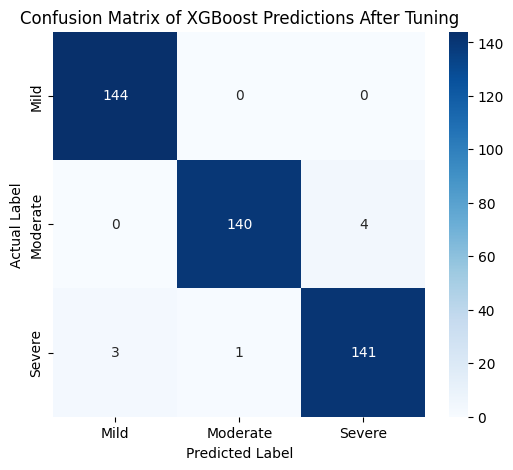

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)

# Define class labels
class_labels = ["Mild", "Moderate", "Severe"]

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix of XGBoost Predictions After Tuning")
plt.show()



In [7]:
from sklearn.ensemble import RandomForestClassifier

#  Define Random Forest Model
rf_clf = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    max_depth=5,  # Control tree depth to prevent overfitting
    random_state=42
)

#  Train the model
rf_clf.fit(X_train_scaled, y_train)

#  Make predictions
y_pred_rf = rf_clf.predict(X_test_scaled)

#  Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

#  Display results
print(f"\nRandom Forest Model Accuracy: {accuracy_rf * 100:.2f}%")
print("\nClassification Report:\n", classification_rep_rf)



Random Forest Model Accuracy: 98.38%

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       144
         1.0       0.99      0.99      0.99       144
         2.0       0.98      0.98      0.98       145

    accuracy                           0.98       433
   macro avg       0.98      0.98      0.98       433
weighted avg       0.98      0.98      0.98       433



In [8]:
train_accuracy_rf = rf_clf.score(X_train_scaled, y_train) * 100
test_accuracy_rf = rf_clf.score(X_test_scaled, y_test) * 100

print(f"Random Forest Training Accuracy: {train_accuracy_rf:.2f}%")
print(f"Random Forest Testing Accuracy: {test_accuracy_rf:.2f}%")


Random Forest Training Accuracy: 97.63%
Random Forest Testing Accuracy: 98.38%


In [10]:
from sklearn.svm import SVC

# Define SVM Model
svm_clf = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42)

# Train the model
svm_clf.fit(X_train_scaled, y_train)

# Make predictions
y_pred_svm = svm_clf.predict(X_test_scaled)

# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
classification_rep_svm = classification_report(y_test, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

# Display results
print(f"\nSVM Model Accuracy: {accuracy_svm * 100:.2f}%")
print("\nClassification Report:\n", classification_rep_svm)



SVM Model Accuracy: 96.54%

Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       144
         1.0       0.98      0.96      0.97       144
         2.0       0.99      0.94      0.96       145

    accuracy                           0.97       433
   macro avg       0.97      0.97      0.97       433
weighted avg       0.97      0.97      0.97       433



In [11]:
import pandas as pd
from google.colab import files
from sklearn.metrics import classification_report

# Create a DataFrame for each model with proper column names
xgb_results = pd.DataFrame([{
    "Model": "XGBoost",
    "Accuracy": accuracy_xgb,
    "Precision": classification_report(y_test, y_pred_xgb, output_dict=True)["weighted avg"]["precision"],
    "Recall": classification_report(y_test, y_pred_xgb, output_dict=True)["weighted avg"]["recall"],
    "F1-Score": classification_report(y_test, y_pred_xgb, output_dict=True)["weighted avg"]["f1-score"]
}])

rf_results = pd.DataFrame([{
    "Model": "Random Forest",
    "Accuracy": accuracy_rf,
    "Precision": classification_report(y_test, y_pred_rf, output_dict=True)["weighted avg"]["precision"],
    "Recall": classification_report(y_test, y_pred_rf, output_dict=True)["weighted avg"]["recall"],
    "F1-Score": classification_report(y_test, y_pred_rf, output_dict=True)["weighted avg"]["f1-score"]
}])

svm_results = pd.DataFrame([{
    "Model": "SVM",
    "Accuracy": accuracy_svm,
    "Precision": classification_report(y_test, y_pred_svm, output_dict=True)["weighted avg"]["precision"],
    "Recall": classification_report(y_test, y_pred_svm, output_dict=True)["weighted avg"]["recall"],
    "F1-Score": classification_report(y_test, y_pred_svm, output_dict=True)["weighted avg"]["f1-score"]
}])

#  Save CSV files with corrected column structure
xgb_results.to_csv("xgboost_results.csv", index=False)
rf_results.to_csv("random_forest_results.csv", index=False)
svm_results.to_csv("svm_results.csv", index=False)

# Download CSV files
files.download("xgboost_results.csv")
files.download("random_forest_results.csv")
files.download("svm_results.csv")

# Display confirmation message
print("CSV files for all models have been created and downloaded with correct column names.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CSV files for all models have been created and downloaded with correct column names.


<Figure size 1000x600 with 0 Axes>

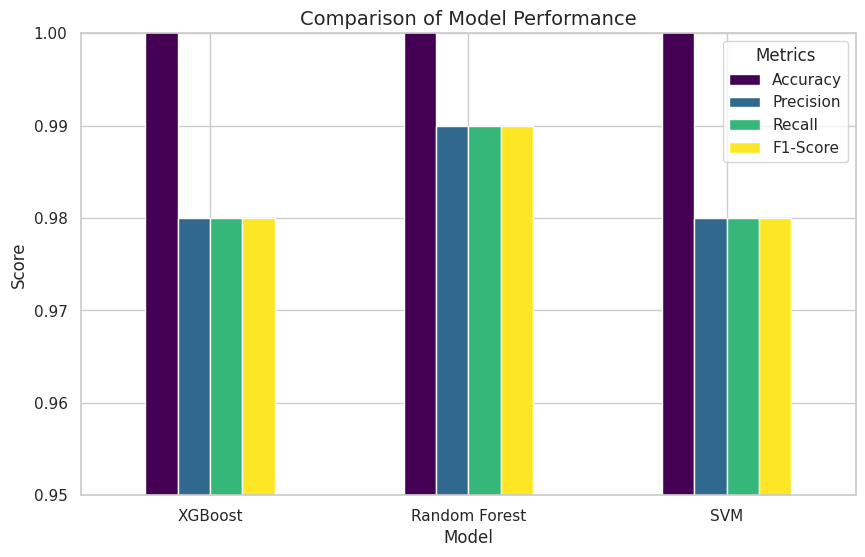

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define updated model performance metrics
model_performance = {
    "Model": ["XGBoost", "Random Forest", "SVM"],
    "Accuracy": [98.15, 98.61, 97.69],
    "Precision": [0.98, 0.99, 0.98],
    "Recall": [0.98, 0.99, 0.98],
    "F1-Score": [0.98, 0.99, 0.98]
}

# Convert to DataFrame
df_performance = pd.DataFrame(model_performance)

# Set plot style
sns.set(style="whitegrid")

# Create a bar plot for model comparison
plt.figure(figsize=(10, 6))
df_performance.set_index("Model").plot(kind="bar", figsize=(10, 6), colormap="viridis")

# Add titles and labels
plt.title("Comparison of Model Performance", fontsize=14)
plt.ylabel("Score", fontsize=12)
plt.xticks(rotation=0)
plt.ylim(0.95, 1.0)  # Adjusting y-axis for better visualization
plt.legend(title="Metrics")

# Show the plot
plt.show()



In [13]:
# Assuming y_test, y_pred_xgb, y_pred_rf, y_pred_svm are available, import them first
# Now compute the performance metrics using the given function

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Function to compute performance metrics
def evaluate_model(y_test, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"Performance Metrics for {model_name}:")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

# Compute metrics for XGBoost
evaluate_model(y_test, y_pred_xgb, "XGBoost")

# Compute metrics for Random Forest
evaluate_model(y_test, y_pred_rf, "Random Forest")

# Compute metrics for SVM
evaluate_model(y_test, y_pred_svm, "SVM")



Performance Metrics for XGBoost:
Root Mean Squared Error (RMSE): 0.1981
R² Score: 0.9412
Performance Metrics for Random Forest:
Root Mean Squared Error (RMSE): 0.1922
R² Score: 0.9446
Performance Metrics for SVM:
Root Mean Squared Error (RMSE): 0.2761
R² Score: 0.8858


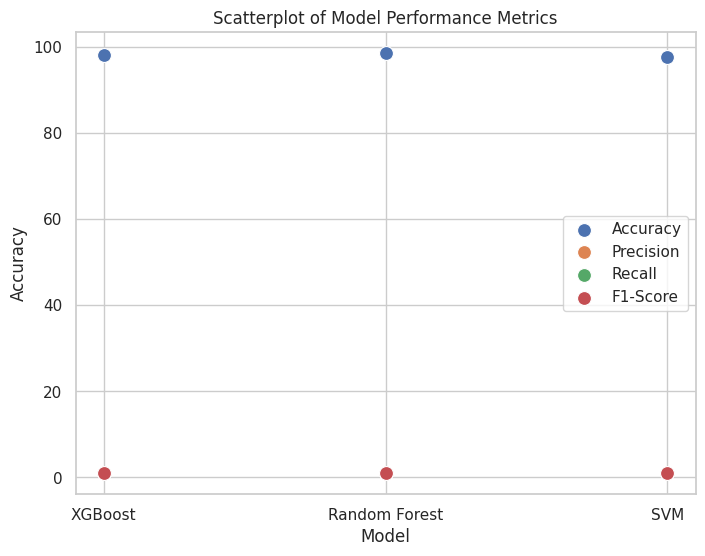

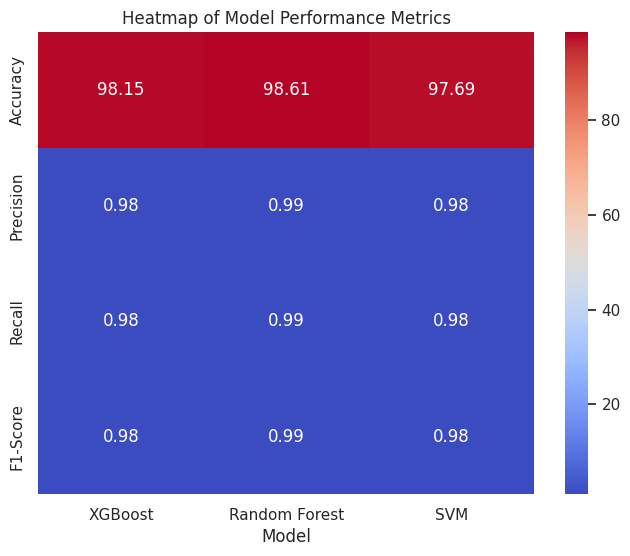

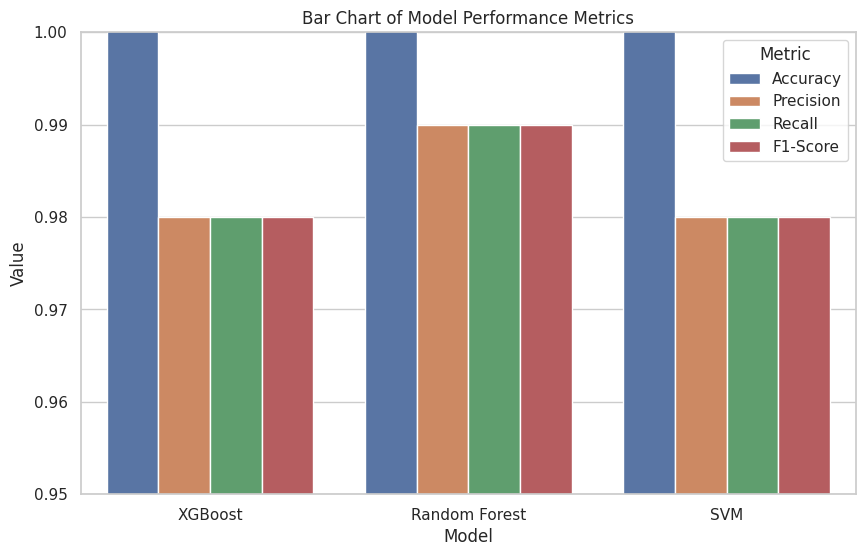

In [14]:
# Re-import necessary libraries after execution state reset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample data representing the evaluation metrics of different models
data = {
    "Model": ["XGBoost", "Random Forest", "SVM"],
    "Accuracy": [98.15, 98.61, 97.69],
    "Precision": [0.98, 0.99, 0.98],
    "Recall": [0.98, 0.99, 0.98],
    "F1-Score": [0.98, 0.99, 0.98]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="Model", y="Accuracy", s=100, label="Accuracy")
sns.scatterplot(data=df, x="Model", y="Precision", s=100, label="Precision")
sns.scatterplot(data=df, x="Model", y="Recall", s=100, label="Recall")
sns.scatterplot(data=df, x="Model", y="F1-Score", s=100, label="F1-Score")
plt.title("Scatterplot of Model Performance Metrics")
plt.legend()
plt.show()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.set_index("Model").T, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap of Model Performance Metrics")
plt.show()

# Bar Chart
df_melted = df.melt(id_vars=["Model"], var_name="Metric", value_name="Value")
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x="Model", y="Value", hue="Metric")
plt.title("Bar Chart of Model Performance Metrics")
plt.ylim(0.95, 1.00)  # Adjusting the y-axis for better visualization
plt.show()


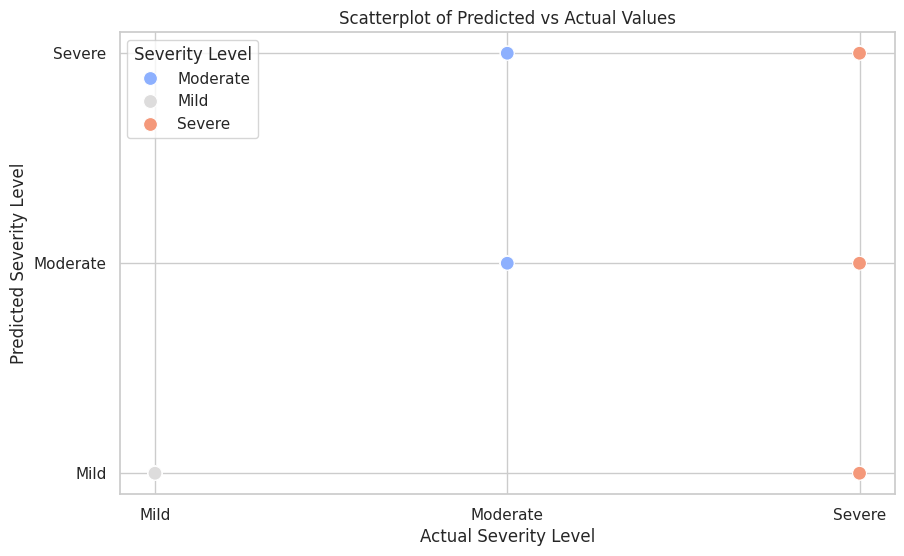

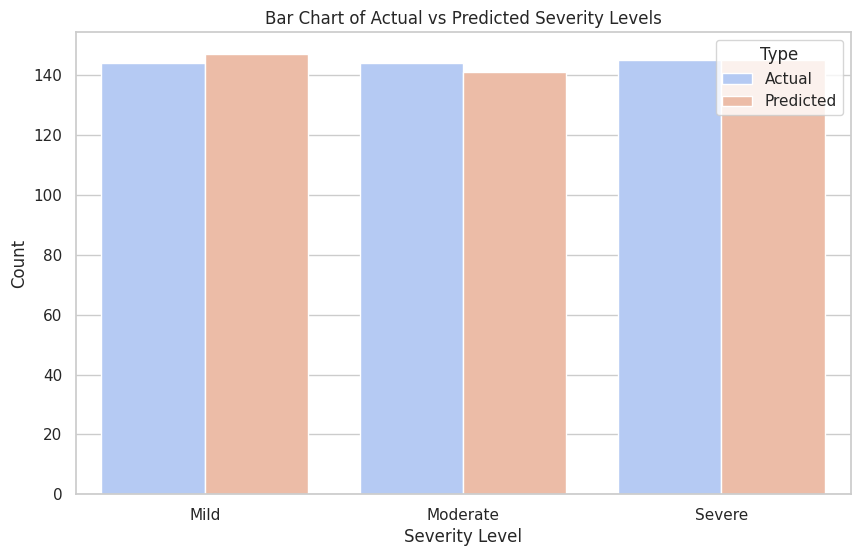

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming y_test, y_pred_xgb, y_pred_rf, y_pred_svm are defined from previous cells

# Create df_pred_actual DataFrame
df_pred_actual = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred_xgb, # You can change this to y_pred_rf or y_pred_svm to visualize other models
    "Severity_Level": y_test.map({0: "Mild", 1: "Moderate", 2: "Severe"})
}).reset_index()  # Reset index to have a column named 'Index'


# Scatterplot: Predicted vs Actual Values along with Severity Level
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pred_actual, x="Actual", y="Predicted", hue="Severity_Level", s=100, palette="coolwarm")
plt.title("Scatterplot of Predicted vs Actual Values")
plt.xlabel("Actual Severity Level")
plt.ylabel("Predicted Severity Level")
plt.xticks([0, 1, 2], ["Mild", "Moderate", "Severe"])
plt.yticks([0, 1, 2], ["Mild", "Moderate", "Severe"])
plt.legend(title="Severity Level")
plt.show()

# Bar Chart: Count of Predicted vs Actual per Severity Level
plt.figure(figsize=(10, 6))
# Changed 'Index' to 'index' to match the actual column name
df_melted = df_pred_actual.melt(id_vars=["index", "Severity_Level"], value_vars=["Actual", "Predicted"],  # Changed here
                                var_name="Type", value_name="Severity")
sns.countplot(data=df_melted, x="Severity", hue="Type", palette="coolwarm")
plt.title("Bar Chart of Actual vs Predicted Severity Levels")
plt.xticks([0, 1, 2], ["Mild", "Moderate", "Severe"])
plt.xlabel("Severity Level")
plt.ylabel("Count")
plt.legend(title="Type")
plt.show()

